# CEBRA feature selection

cebra is a method to use time information, to label behavior variables either 'near' or 'far', and use contrastive learning to train for an embedding.
the embedding will be a nice visualization of neural maniford, and provide the behavior variable mapping in neural (embedding) space.

here we want the embedding learning can focus on the label that makes sense, and ignore the labels that does not.
currently (as of mar 25 i have not yet fully read the cebra code) im not sure if the base cebra can do this. let try.

## outline
- simulation data
- run cebra
- check res

### imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
# import
from matplotlib import pyplot as plt
import numpy as np
import cebra
from cebra import CEBRA
import pandas as pd
import tempfile
from pathlib import Path
import sys
import os
import pickle
from pathlib import Path

In [4]:

import configparser
config = configparser.ConfigParser()
config.read_file(open('../../privateconfig'))
resdir = Path(config['Datafolder']['data'])
workdir = Path(config['Codefolder']['workspace'])
os.chdir(workdir)

In [5]:

from notification import notify

## Simulation data
here we will make some simualtion data to test our hypothesis that the base cebra can find the intrinsic label and ignores the correlated label.

neural data:
- r: represent the neural data. we need some more dim but we can just duplicate them or make them linearly dependent. 

labels:
- x1: represent the intrinsic label.
- x2: represent the correlated label.

In [6]:
# # real data as a template
# with open(f'{workdir}/test/neural/cebra/test', 'rb') as f:
#     (neural_data, continuous_label) = pickle.load(f)
# neural_data.shape, continuous_label.shape

In [30]:
# linear data. (discrete correlation)
r = torch.linspace(0, 1, 10000+1)
neural_data = torch.vstack([r, r, r]).T
r0 = r+torch.rand_like(r)*0.1
r1 = r+torch.rand_like(r)*0.1

x1 = r0+torch.rand_like(r)*0.1
x2 = r0+r1+torch.rand_like(r1)*0.1
continuous_label = torch.vstack([x1, x2]).T


neural_data.shape, continuous_label.shape

(torch.Size([10001, 3]), torch.Size([10001, 2]))

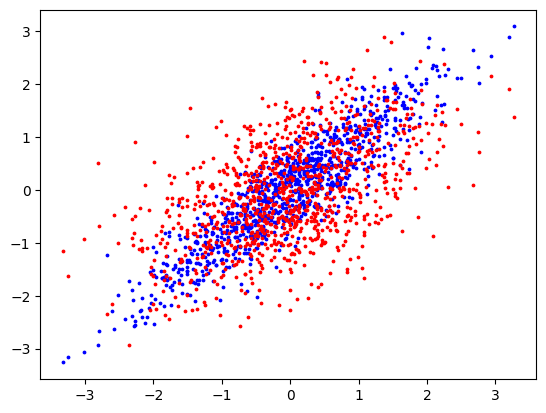

In [92]:
# gaussian data (continues correlation)


mean = torch.tensor([0.0, 0.0, 0.0])
covariance = torch.tensor([[1.0, 0.9, 0.5],
                            [0.9, 1.0, 0.3],
                            [0.5, 0.3, 1.0]])
distribution=torch.distributions.MultivariateNormal(mean, covariance)

gaussian_data = distribution.sample((1000,))
r, x1, x2 = gaussian_data[:,0], gaussian_data[:,1],gaussian_data[:,2]
plt.scatter(r, x1,color='blue',s=3)


plt.scatter(r, x2, color='red', s=3)

neural_data=r.reshape(-1,1)
continuous_label = torch.vstack([x1, x2]).T

Correlation coefficient between original and new data: 0.7628939319857213


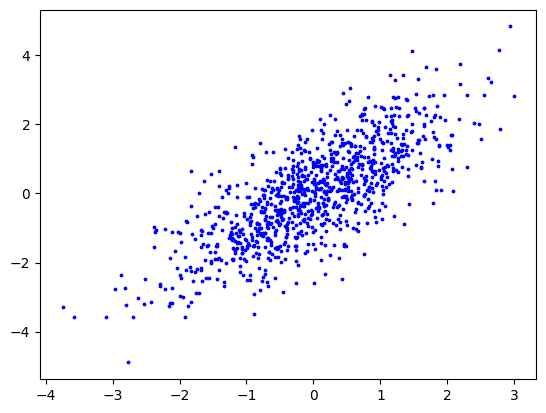

In [104]:


def gen_data_corr(original_data,corr = 0.5):
    return  original_data + torch.sqrt(torch.tensor(1 - corr**2)) * torch.randn(1000, 1)


original_data = torch.randn(1000, 1)
new_data = gen_data_corr(original_data)
corr_coef = np.corrcoef(original_data.squeeze(), new_data.squeeze())[0, 1]
print("Correlation coefficient between original and new data:", corr_coef)

plt.scatter(original_data,new_data ,color='blue',s=3)



In [110]:
x = torch.randn(1000, 1)
x1=gen_data_corr(x, corr=0.7)
x2=gen_data_corr(x, corr=0.7)
r1,r2,r3=gen_data_corr(x1, corr=0.7),gen_data_corr(x1, corr=0.7),gen_data_corr(x1, corr=0.7)
continuous_label = torch.hstack([x1, x2])
neural_data = torch.hstack([r1, r2,r3])
neural_data.shape, continuous_label.shape

(torch.Size([1000, 3]), torch.Size([1000, 2]))

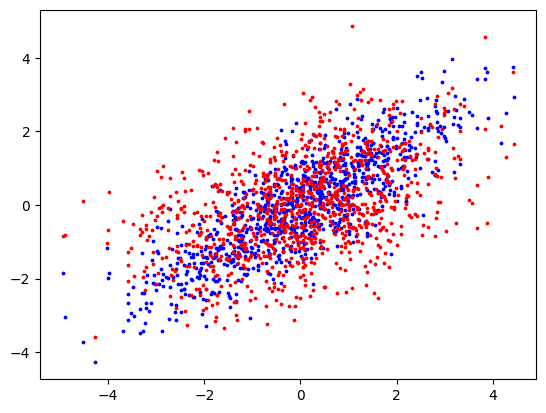

In [112]:
plt.scatter(neural_data[:,0],continuous_label[:,0] ,color='blue',s=3)
plt.scatter(neural_data[:,0],continuous_label[:,1] ,color='red',s=3)

# model and train

In [119]:
timesteps = neural_data.shape[0]
neurons = neural_data.shape[1]
out_dim = 2
max_iterations = 99
time_offsets = 4  # 0.1 s

single_cebra_model = CEBRA(model_architecture='offset10-model',
                           batch_size=None,  # whole dataset
                           learning_rate=0.05,
                           # temperature_mode="auto",
                           temperature=1,
                           output_dimension=out_dim,
                           max_iterations=max_iterations,
                           distance='cosine',
                           conditional='time_delta',
                           device='cuda:0',
                           verbose=True,
                           time_offsets=time_offsets)

In [120]:
#  training
for i in np.arange(9):
    single_cebra_model.fit(neural_data, continuous_label)
    # tmp_file = Path(f'{workdir}/test/neural/cebra/', f'cebra024612_0309fast_{i+1}hr.pt')
    # single_cebra_model.save(tmp_file)
    # notify(f'cebra {i} ready')

  0%|          | 0/99 [00:00<?, ?it/s]

pos: -0.9987 neg:  7.8900 total:  6.8913 temperature:  1.0000: 100%|██████████| 99/99 [00:02<00:00, 42.29it/s]
pos: -0.9858 neg:  7.8744 total:  6.8886 temperature:  1.0000: 100%|██████████| 99/99 [00:02<00:00, 40.44it/s]
pos: -0.6257 neg:  7.4222 total:  6.7965 temperature:  1.0000: 100%|██████████| 99/99 [00:02<00:00, 40.38it/s]
pos: -0.9101 neg:  7.7961 total:  6.8860 temperature:  1.0000: 100%|██████████| 99/99 [00:02<00:00, 42.74it/s]
pos: -1.0000 neg:  7.8916 total:  6.8916 temperature:  1.0000: 100%|██████████| 99/99 [00:02<00:00, 40.27it/s]
pos: -1.0000 neg:  7.8916 total:  6.8916 temperature:  1.0000: 100%|██████████| 99/99 [00:02<00:00, 40.70it/s]
pos: -0.6466 neg:  7.4595 total:  6.8129 temperature:  1.0000: 100%|██████████| 99/99 [00:02<00:00, 44.41it/s]
pos: -0.6696 neg:  7.4900 total:  6.8204 temperature:  1.0000: 100%|██████████| 99/99 [00:02<00:00, 41.51it/s]
pos: -0.6832 neg:  7.5145 total:  6.8313 temperature:  1.0000: 100%|██████████| 99/99 [00:02<00:00, 40.05it/s]


Text(0.5, 1.0, 'training loss')

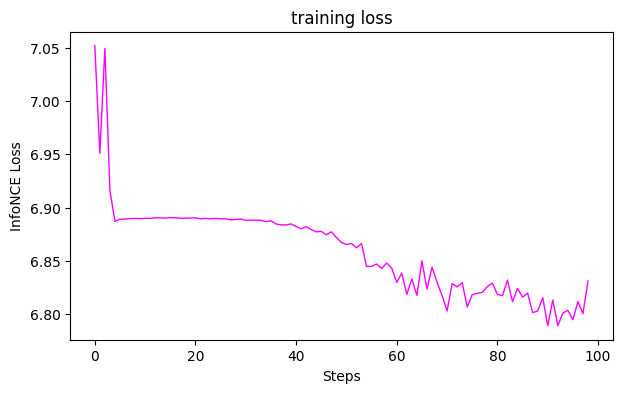

In [121]:
%matplotlib inline

ax=cebra.plot_loss(single_cebra_model)
ax.set_title('training loss')

# ax=cebra.plot_temperature(single_cebra_model)
# ax.set_title('temperature')


# Analysis

In [122]:
embedding = single_cebra_model.transform(neural_data)

### plot functions

In [123]:
from matplotlib import pyplot as plt

def plot_embedding_contrast(ax, embedding, label, gray = False, beh_idx=(0,1), idx_order = (0,1,2)):
    if not gray:
        r_cmap = 'cool'
        r_c = label[:, beh_idx[0]]-label[:, beh_idx[1]]
    else:
        r_cmap = None
        r_c = 'gray'
    idx1, idx2, idx3 = idx_order
    r=ax.scatter(embedding [:,idx1],
               embedding [:,idx2],
               embedding [:,idx3],
               c=r_c,
            #    vmin=0,
            #    vmax=1,
               cmap=r_cmap, s=0.5)
    plt.colorbar(r)
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.set_ticks([-1,0,1])
    ax.yaxis.set_ticks([-1,0,1])
    ax.zaxis.set_ticks([-1,0,1])
    ax.set_xlabel('dim 1')
    ax.set_ylabel('dim 2')
    ax.set_zlabel('dim 3')
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.axis('equal')
    return ax

def plot_embedding(ax, embedding, label, gray = False, beh_idx=0, idx_order = (0,1,2)):
    if not gray:
        r_cmap = 'cool'
        r_c = label[:, beh_idx]
    else:
        r_cmap = None
        r_c = 'gray'
    idx1, idx2, idx3 = idx_order
    r=ax.scatter(embedding [:,idx1],
               embedding [:,idx2],
               embedding [:,idx3],
               c=r_c,
               vmin=0,
               vmax=1,
               cmap=r_cmap, s=0.5)
    plt.colorbar(r)
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.set_ticks([-1,0,1])
    ax.yaxis.set_ticks([-1,0,1])
    ax.zaxis.set_ticks([-1,0,1])
    ax.set_xlabel('dim 1')
    ax.set_ylabel('dim 2')
    ax.set_zlabel('dim 3')
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.axis('equal')
    return ax

def plot_embedding2d(ax, embedding, label, gray = False, beh_idx=0, idx_order = (0,1)):
    if not gray:
        r_cmap = 'cool'
        r_c = label[:, beh_idx]
    else:
        r_cmap = None
        r_c = 'gray'
    idx1, idx2 = idx_order
    r=ax.scatter(embedding [:,idx1],
               embedding [:,idx2],
               c=r_c,
               vmin=0,
               vmax=1,
               cmap=r_cmap, s=0.5)
    plt.colorbar(r)
    ax.grid(False)
    ax.xaxis.set_ticks([-1,0,1])
    ax.yaxis.set_ticks([-1,0,1])
    ax.set_xlabel('dim 1')
    ax.set_ylabel('dim 2')
    ax.axis('equal')
    return ax

### 2d embedding

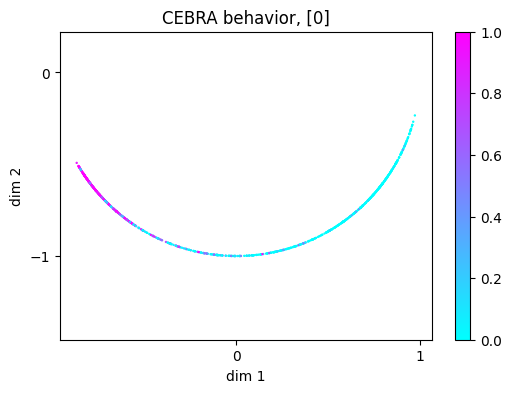

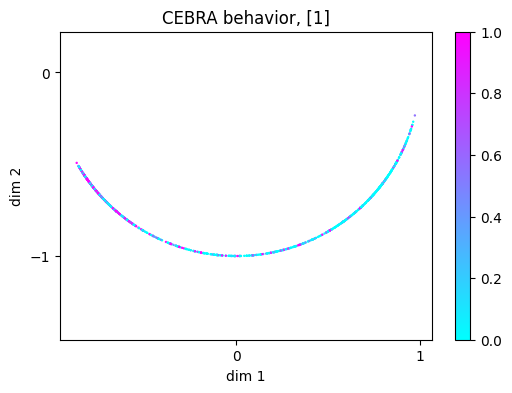

In [124]:
# %matplotlib inline

for beh_idx in range(continuous_label.shape[1]):

    fig = plt.figure(figsize=(6,4))
    ax1 = plt.subplot(111)
    ax1 = plot_embedding2d(ax1, embedding, continuous_label, beh_idx=beh_idx)
    ax1.set_title(f'CEBRA behavior, {[beh_idx]}')
    plt.show()

we expect the two dim shows very similar embedding, because they are tightly correlated.

## check the model weights

singl